In [2]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import geopandas as gpd

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression

### Задача:

Прогноз продаж одной из популярных моделей [фичерфонов](https://ru.wikipedia.org/wiki/%D0%A4%D0%B8%D1%87%D0%B5%D1%80%D1%84%D0%BE%D0%BD) (на картинке ниже пример похожего устройства) в салонах МегаФона
![](https://39.img.avito.st/640x480/8468720439.jpg)

### Исходные данные:

Датасет содержит следующие поля:

1. `point_id` - Индентификатор салона
2. `lon` - Долгота точки
3. `lat` - Широта точки
4. `target` - Значение таргета, усредненное за несколько месяцев и отнормированное

### Требования к решению и советы:

Ниже приведен список из нескольких важных пунктов, необходимых для решения задания. Выполнение каждого из пунктов влияет на итоговую оценку. Вы можете выполнить каждый из пунктов разными способами, самым лучшим будет считаться вариант, когда всё получение и обработка данных будут реализованы на Питоне (пример: вы можете скачать данные из OSM через интерфейс на сайте overpass-turbo или с помощью библиотек `overpass`/`requests`. Оба варианта будут зачтены, но больше баллов можно заработать во втором случае)



1. Салоны расположены в нескольких разных городах, вам необходимо **определить город для каждого салона** (это понадобится во многих частях задания). К этому есть разные подходы. Вы можете провести [обратное геокодирование](https://en.wikipedia.org/wiki/Reverse_geocoding) с помощью геокодера [Nominatim](https://nominatim.org/), доступного через библиотеку `geopy` примерно вот так:
```python
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="specify_your_app_name_here")
location = geolocator.reverse("52.509669, 13.376294")
print(location.address)
```
В таком случае, вам придется обрабатывать полученную строку адреса, чтобы извлечь название города. Также вы можете скачать из OSM или найти в любом другом источнике границы административно территориальных границ России и пересечь с ними датасет с помощью `geopandas.sjoin` (этот вариант более надежный, но нужно будет разобраться с тем, как устроены границы АТД в OSM, обратите внимание на [этот тег](https://wiki.openstreetmap.org/wiki/Key:admin_level))


2. **Используйте данные OSM**: подумайте, какие объекты могут влиять на продажи фичерфонов. Гипотеза: такие телефоны покупают люди, приезжающие в город или страну ненадолго, чтобы вставить туда отдельную симкарту для роуминга. Можно попробовать использовать местоположения железнодорожных вокзалов (изучите [этот тег](https://wiki.openstreetmap.org/wiki/Tag:railway%3Dstation)). Необходимо использовать хотя бы 5 разных типов объектов из OSM. Скорее всего, вам придется качать данные OSM отдельно для разных городов (см. пример для Нью-Йорка из лекции)


3. **Используйте разные способы генерации признаков**: описать положение салона МегаФона относительно станций метро можно разными способами - найти ***расстояние до ближайшей станции***, или же посчитать, сколько станций попадает в ***500 метровую буферную зону*** вокруг салона. Такие признаки будут нести разную информацию. Так же попробуйте поэкспериментировать с размерами буферных зон (представьте, что значат в реальности радиусы 100, 500, 1000 метров). Попробуйте посчитать расстояние до центра города, до других объектов.

4. **Сделайте визуализации**: постройте 2-3 карты для какого нибудь из городов - как распределен в пространстве таргет, где находятся объекты, полученные вами из OSM. Можете использовать любой инструмент - обычный `plot()`, `folium`, `keplergl`. Если выберете Кеплер, обязательно сохраните в файл конфиг карты, чтобы ее можно было воспроизвести. Сделать это можно вот так:

```python
import json
json_data = kepler_map.config
with open('kepler_config.json', 'w') as outfile:
    json.dump(json_data, outfile)
```
5. Задание не ограничено приведенными выше пунктами, попробуйте нагенерировать интересных признаков, найти в интернете дополнительные данные (в таком случае в комментарии к коду укажите ссылку на ресурс, откуда взяли данные)



6. Это довольно сложная задача - датасет очень маленький, данные по своей природе довольно случайны. Поэтому место и скор на Kaggle не будут играть решающую роль в оценке, но позволят заработать дополнительные баллы

### Read data

In [421]:
train = gpd.read_file('mf_geo_train.csv')
test = gpd.read_file('mf_geo_test.csv')

In [422]:
train

,point_id,lon,lat,target,geometry
0,ommNZCUV,37.590776,55.84863000000001,-0.34815737860381524,None
1,nMe2LHPb,37.784209999999995,55.750271,1.294206304946465,None
2,ZgodVRqB,39.635721000000004,47.21333,-1.0396789295723543,None
3,0t2jNYdz,37.704570000000004,55.782019999999996,-1.1693392203789554,None
4,U27W4QJ7,37.643983,55.730188,-0.08883679699061309,None
...,...,...,...,...,...
420,AA8hN7bJ,37.628765,55.740664,0.21370388155812275,None
421,uNw6t6xk,37.586825,55.794233,-0.002396603119545705,None
422,Ap42ei8k,37.67879,55.772909999999996,-0.9100186387657532,None
423,rn9A8r62,37.75213,55.619640000000004,-0.32654733013604836,None


In [4]:
test

,point_id,lon,lat,target,geometry
0,F4lXR1cG,37.681242,55.74804,0.0091,None
1,4LJu4GTf,60.580909999999996,56.79586,0.0091,None
2,kLuAAN3s,37.598614000000005,55.78135699999999,0.0091,None
3,OxQHvaNu,37.794051,55.717468000000004,0.0091,None
4,paQsTa1K,49.213026,55.748290000000004,0.0091,None
...,...,...,...,...,...
102,y8oQuX5v,30.353777,60.049792000000004,0.0091,None
103,4nmfqUw0,92.928927,56.116262,0.0091,None
104,N9O45mAh,93.01599300000001,56.023697,0.0091,None
105,h2InCLKa,30.381171999999996,59.871149,0.0091,None


### hw

#### overpass

In [333]:
from geopy.geocoders import Nominatim
import re
import requests

In [13]:
import shapely.geometry as sg
import matplotlib.pyplot as plt
import shapely.wkt
from shapely.geometry import Point

In [612]:
#train = test #для тестовой части

In [613]:
geom = []
for i, j in train[['lon', 'lat']].values:
    geom.append(Point(np.round(float(i),6), np.round(float(j),6)))

k = 0
for i in geom:
    train.iloc[k,4] = i
    k+=1

In [424]:
train.head()

,point_id,lon,lat,target,geometry
0,ommNZCUV,37.590776,55.84863000000001,-0.34815737860381524,POINT (37.59078 55.84863)
1,nMe2LHPb,37.784209999999995,55.750271,1.294206304946465,POINT (37.78421 55.75027)
2,ZgodVRqB,39.635721000000004,47.21333,-1.0396789295723543,POINT (39.63572 47.21333)
3,0t2jNYdz,37.704570000000004,55.782019999999996,-1.1693392203789554,POINT (37.70457 55.78202)
4,U27W4QJ7,37.643983,55.730188,-0.08883679699061309,POINT (37.64398 55.73019)


In [3]:
adlvl4 = gpd.read_file('GeoJSON/admin_level_4.geojson')
adlvl4 = adlvl4[['name', 'geometry']]

NameError: name 'train' is not defined

In [614]:
msk_spb = gpd.sjoin(train, adlvl4, op='within')

In [615]:
msk = msk_spb[msk_spb['name'] == 'Москва']
msk_spb = msk.append(msk_spb[msk_spb['name'] == 'Санкт-Петербург'])

In [6]:
adlvl6 = gpd.read_file('GeoJSON/admin_level_6.geojson')
adlvl6 = adlvl6[['name', 'geometry']]

In [616]:
ru = gpd.sjoin(train,adlvl6,op='within')
ru = ru.append(msk_spb)
ru

,point_id,lon,lat,target,geometry,index_right,name
1,4LJu4GTf,60.580909999999996,56.79586,0.0091,POINT (60.58091 56.79586),2347,городской округ Екатеринбург
11,QquqDdRl,60.630766,56.863482999999995,0.0091,POINT (60.63077 56.86348),2347,городской округ Екатеринбург
40,TWUIwCah,60.58832099999999,56.902156999999995,0.0091,POINT (60.58832 56.90216),2347,городской округ Екатеринбург
46,6PiHBiPm,60.818936,56.759049,0.0091,POINT (60.81894 56.75905),2347,городской округ Екатеринбург
50,kuGZ4yXA,60.608227,56.782652,0.0091,POINT (60.60823 56.78265),2347,городской округ Екатеринбург
...,...,...,...,...,...,...,...
97,b8VUVBle,30.318213,59.926476,0.0091,POINT (30.31821 59.92648),45,Санкт-Петербург
98,h3S4qdms,30.334946000000002,60.067586,0.0091,POINT (30.33495 60.06759),45,Санкт-Петербург
102,y8oQuX5v,30.353777,60.049792000000004,0.0091,POINT (30.35378 60.04979),45,Санкт-Петербург
105,h2InCLKa,30.381171999999996,59.871149,0.0091,POINT (30.38117 59.87115),45,Санкт-Петербург


In [11]:
train

,point_id,lon,lat,target,geometry
0,ommNZCUV,37.590776,55.84863000000001,-0.34815737860381524,None
1,nMe2LHPb,37.784209999999995,55.750271,1.294206304946465,None
2,ZgodVRqB,39.635721000000004,47.21333,-1.0396789295723543,None
3,0t2jNYdz,37.704570000000004,55.782019999999996,-1.1693392203789554,None
4,U27W4QJ7,37.643983,55.730188,-0.08883679699061309,None
...,...,...,...,...,...
420,AA8hN7bJ,37.628765,55.740664,0.21370388155812275,None
421,uNw6t6xk,37.586825,55.794233,-0.002396603119545705,None
422,Ap42ei8k,37.67879,55.772909999999996,-0.9100186387657532,None
423,rn9A8r62,37.75213,55.619640000000004,-0.32654733013604836,None


In [617]:
ru['name'].value_counts()

Москва                             40
Санкт-Петербург                    21
городской округ Казань              7
городской округ Самара              7
городской округ Новосибирск         7
городской округ Красноярск          5
городской округ Нижний Новгород     5
городской округ Екатеринбург        5
городской округ Уфа                 5
городской округ Ростов-на-Дону      5
Name: name, dtype: int64

In [373]:
reg = adlvl4

In [618]:
ind = ru['index_right']

In [619]:
ru = gpd.sjoin(ru.drop(columns = 'index_right'),reg,op='within')

In [620]:
ru['index_right'] = ind

#### Собрали датасет, определив город и область

In [621]:
ru.head()

,point_id,lon,lat,target,geometry,name_left,index_right,name_right
1,4LJu4GTf,60.580909999999996,56.79586,0.0091,POINT (60.58091 56.79586),городской округ Екатеринбург,2347,Свердловская область
11,QquqDdRl,60.630766,56.863482999999995,0.0091,POINT (60.63077 56.86348),городской округ Екатеринбург,2347,Свердловская область
40,TWUIwCah,60.58832099999999,56.902156999999995,0.0091,POINT (60.58832 56.90216),городской округ Екатеринбург,2347,Свердловская область
46,6PiHBiPm,60.818936,56.759049,0.0091,POINT (60.81894 56.75905),городской округ Екатеринбург,2347,Свердловская область
50,kuGZ4yXA,60.608227,56.782652,0.0091,POINT (60.60823 56.78265),городской округ Екатеринбург,2347,Свердловская область


#### 2

In [24]:
import overpass
from geopy import distance
import pandas

In [25]:
api = overpass.API(endpoint="https://overpass.kumi.systems/api/interpreter")

In [26]:
amnts = ['index_right','closest_prison', 'closest_railway', 'closest_tram/subway', 'closest_military', 'closest_areo_reg', 'social_facility', 'closest_camp_reg', 'closest_subway']

In [349]:
requests = pd.DataFrame(data = np.zeros((1,8)), columns = amnts[1:])

requests.iloc[0,0] = '["amenity"="prison"]'
requests.iloc[0,1] = '["railway"="station"]'
requests.iloc[0,2] = '["railway"="tram"]'
requests.iloc[0,3] = '["landuse"="military"]'
requests.iloc[0,4] = '["aeroway"="aerodrome"]'
requests.iloc[0,5] = '["amenity"="social_facility"]'
requests.iloc[0,6] = '["leisure"="summer_camp"]'
requests.iloc[0,7] = '["railway"="subway_entrance"]'

requests

,closest_prison,closest_railway,closest_tram/subway,closest_military,closest_areo_reg,social_facility,closest_camp_reg,closest_subway
0,"[""amenity""=""prison""]","[""railway""=""station""]","[""railway""=""tram""]","[""landuse""=""military""]","[""aeroway""=""aerodrome""]","[""amenity""=""social_facility""]","[""leisure""=""summer_camp""]","[""railway""=""subway_entrance""]"


In [622]:
ru = ru.sort_values('index_right')

In [433]:
ru.tail()

,point_id,lon,lat,target,geometry,name_left,index_right,name_right
68,NTjDKBtL,92.865583,56.009935999999996,-0.30493728166828155,POINT (92.86558 56.00994),городской округ Красноярск,2349,Красноярский край
24,Fcqb4WDt,92.931228,56.004484,-0.17527699086168047,POINT (92.93123 56.00448),городской округ Красноярск,2349,Красноярский край
18,ejjC2aU3,92.974951,56.014022,-0.4345975724748826,POINT (92.97495 56.01402),городской округ Красноярск,2349,Красноярский край
5,ci9r9Fr2,92.926002,56.06590799999999,-0.21849708779721416,POINT (92.92600 56.06591),городской округ Красноярск,2349,Красноярский край
159,HccXdHMK,92.907574,56.032916,0.17048378462258906,POINT (92.90757 56.03292),городской округ Красноярск,2349,Красноярский край


#### Эта функция принимает на вход геодатасет из обьектов, считает расстояние от каждой точки города до каждого из обьектов и выбирает наименьшее для каждой точки

In [380]:
def distances(ru, amenities, index):    
    dists = np.zeros((ru[ru['index_right'] == index].shape[0], amenities.shape[0]))
    d =[]
    k = 0
    for point in ru[ru['index_right'] == index]['geometry']:
        m = 0
        for i in amenities['geometry']: 
            if type(i) == shapely.geometry.linestring.LineString:
                amenity = i.coords[0][1],i.coords[0][0]              
            else:
                 amenity = i.y, i.x
            city = point.y, point.x
            dists[k,m] = distance.geodesic(city, amenity).km
            m += 1
        k+=1
    k = 0
    closest_amenity = np.zeros(dists.shape[0])
    for i in np.argmin(dists, axis = 1):
        closest_amenity[k] = np.round(dists[k,i], 2)
        k+=1
    return closest_amenity


#### Это основная функция дз: для каждого из городов через overpass api делает запрос по всем видам amenities, которые нас интересуют, считает расстояния до обьектов, на выходе получаем датафрейм из фичей для модели. При чем для таких фичей как аэропорты и детские лагеря ищет по областям, для фичей внутри города - по городу

In [623]:
df_dist = pd.DataFrame(data = np.zeros((ru.shape[0],len(amnts))),columns = amnts)
c = True
idx = 0

for feature in amnts[1:]:
    
    start = 0
    step = 0
    
    for point, geom, name, ind, name_r in ru[['point_id', 'geometry','name_left', 'index_right','name_right']].values:
        
        if ind == 45 or ind == 64:
            lvl = 4
        else:
            lvl = 6
            
        if len(re.findall('reg',feature)) != 0:
            lvl = 4
            if name == 'Москва':
                name = 'Московская область'
            else:
                name = name_r

        if ind != idx:
            #print(ind, idx)
            idx = ind
            req = requests[feature][0]
            response = api.get(f'area[admin_level={lvl}]["name"="{name}"][boundary=administrative]->.arr;(node(area.arr){req};way(area.arr){req};)', verbosity='body geom')
            df = gpd.GeoDataFrame.from_features(response)
            if df.shape[0] == 0:
                #print('bad response', name, feature)
                continue
            ds = distances(ru, df, ind)
            step = len(ds) - 1
            if start == df_dist.shape[0]:
                continue
            df_dist.loc[start:start + step, feature] = ds
            if c:
                df_dist.iloc[int(start):int(start + step), 0] = int(ind)
            start = start + step + 1
    c = False        

        

bad response городской округ Самара social_facility
bad response Самарская область closest_camp_reg
bad response Татарстан closest_camp_reg
bad response Ростовская область closest_camp_reg
bad response городской округ Ростов-на-Дону closest_subway
bad response городской округ Уфа closest_subway
bad response городской округ Красноярск closest_subway


In [416]:
df_dist.shape

(425, 10)

In [624]:
c = 0
for i, j, k in df_dist[['social_facility','closest_camp_reg', 'closest_subway']].values:
    #print(k, id,i)
    if i == 0.00:
        df_dist.iloc[c,6] = -1

    if j == 0.00:
        df_dist.iloc[c,7] = -1

    if k == 0.00:
        df_dist.iloc[c,8] = -1

    c += 1

In [32]:
#df_dist = pd.read_csv('df_dist_correct-1.csv')
#df_dist = df_dist.drop(columns='Unnamed: 0')

#### Сделаем датафрейм с координатами центров городов (representative_points), чтобы посчитать еще один признак

In [505]:
city_centers = gpd.GeoDataFrame(data = np.zeros((10,2)), columns = ['name', 'geometry']) 

moscow = adlvl4[adlvl4['name'] == 'Москва']['geometry']
city_centers.iloc[0, 0] = 'Москва'
city_centers.iloc[0, 1] = moscow
city_centers.iloc[1, 0] = 'Санкт-Петербург'
city_centers.iloc[1, 1] = adlvl4[adlvl4['name'] == 'Санкт-Петербург']['geometry']

In [72]:
cities = ru['name_left'].drop_duplicates().values

In [507]:
k = 2
for name, geom in adlvl6[['name', 'geometry']].values:
    if name in cities:
        city_centers.iloc[k, 0] = name
        city_centers.iloc[k, 1] = geom.representative_point()
        k+=1

In [508]:
city_centers

,name,geometry
0,Москва,"(POLYGON ((37.8756653 55.8253424, 37.8760016 5..."
1,Санкт-Петербург,"(POLYGON ((30.08271299999999 59.6760822, 30.07..."
2,городской округ Самара,POINT (50.19521712783634 53.32165980000001)
3,городской округ Новосибирск,POINT (82.96815556020306 54.96556425)
4,городской округ Нижний Новгород,POINT (43.92919136749244 56.28904080000001)
5,городской округ Казань,POINT (49.19029447376678 55.76041925000001)
6,городской округ Ростов-на-Дону,POINT (39.72450056305597 47.26073590000001)
7,городской округ Уфа,POINT (56.04969715406952 54.76354365)
8,городской округ Екатеринбург,POINT (60.62026283053082 56.78980290000001)
9,городской округ Красноярск,POINT (92.87929611372311 56.02290500000001)


In [509]:
msc_centr = adlvl4[adlvl4['name'] == 'Москва']['geometry'].representative_point()
spb_centr = adlvl4[adlvl4['name'] == 'Санкт-Петербург']['geometry'].representative_point()

In [510]:
city_centers.iloc[0,1] = msc_centr
city_centers.iloc[1,1] = spb_centr

In [511]:
city_centers

,name,geometry
0,Москва,POINT (37.35610017398403 55.54987505)
1,Санкт-Петербург,POINT (30.07145571557445 59.9406893)
2,городской округ Самара,POINT (50.19521712783634 53.32165980000001)
3,городской округ Новосибирск,POINT (82.96815556020306 54.96556425)
4,городской округ Нижний Новгород,POINT (43.92919136749244 56.28904080000001)
5,городской округ Казань,POINT (49.19029447376678 55.76041925000001)
6,городской округ Ростов-на-Дону,POINT (39.72450056305597 47.26073590000001)
7,городской округ Уфа,POINT (56.04969715406952 54.76354365)
8,городской округ Екатеринбург,POINT (60.62026283053082 56.78980290000001)
9,городской округ Красноярск,POINT (92.87929611372311 56.02290500000001)


In [625]:
ru.head()

,point_id,lon,lat,target,geometry,name_left,index_right,name_right
106,TQKiIgFt,30.279244,59.94211,0.0091,POINT (30.27924 59.94211),Санкт-Петербург,45,Санкт-Петербург
8,yCrOWDXH,30.246976,60.017233,0.0091,POINT (30.24698 60.01723),Санкт-Петербург,45,Санкт-Петербург
9,eek3uK7b,30.289977,59.959270999999994,0.0091,POINT (30.28998 59.95927),Санкт-Петербург,45,Санкт-Петербург
15,xoC8SVZ6,30.361258000000003,59.943751,0.0091,POINT (30.36126 59.94375),Санкт-Петербург,45,Санкт-Петербург
30,jUjQH6FF,30.318441999999997,59.891787,0.0091,POINT (30.31844 59.89179),Санкт-Петербург,45,Санкт-Петербург


#### Считаем расстояние от каждого магазина до центра города

In [626]:
dd=[]
for geom, name in ru[['geometry','name_left']].values:
    cc = city_centers[city_centers['name'] == name]['geometry'].y.values, city_centers[city_centers['name'] == name]['geometry'].x.values
    p = geom.y, geom.x
    d = np.round(distance.geodesic(p, cc).km,2)
    dd.append(d)

In [627]:
df_dist.insert(9,column = 'city_center_dist', value = dd)

In [628]:
df_dist.rename(columns = {'closest_tram/subway':'closest_tram'}, inplace = True)

In [629]:
df_dist

,index_right,closest_prison,closest_railway,closest_tram,closest_military,closest_areo_reg,social_facility,closest_camp_reg,closest_subway,city_center_dist
0,45.0,5.98,0.25,0.73,0.59,12.70,0.11,8.81,0.08,11.62
1,45.0,13.01,0.94,0.97,2.67,13.04,2.09,1.83,1.16,12.99
2,45.0,6.52,0.14,1.07,1.62,14.67,0.54,6.93,0.22,12.39
3,45.0,2.75,0.08,0.95,0.46,14.19,0.46,9.78,0.13,16.20
4,45.0,4.57,0.10,0.03,2.47,7.95,0.87,14.59,0.03,14.85
...,...,...,...,...,...,...,...,...,...,...
102,2349.0,6.96,4.49,11.66,14.55,1.13,-1.00,-1.00,-1.00,10.84
103,2349.0,5.29,0.33,0.56,3.10,5.53,-1.00,-1.00,-1.00,5.36
104,2349.0,9.01,4.14,1.45,7.01,2.80,-1.00,-1.00,-1.00,9.34
105,2349.0,9.76,3.09,0.06,8.17,6.75,-1.00,-1.00,-1.00,8.52


In [635]:
ru.head()

,point_id,lon,lat,target,geometry,name_left,index_right,name_right
106,TQKiIgFt,30.279244,59.94211,0.0091,POINT (30.27924 59.94211),Санкт-Петербург,45,Санкт-Петербург
8,yCrOWDXH,30.246976,60.017233,0.0091,POINT (30.24698 60.01723),Санкт-Петербург,45,Санкт-Петербург
9,eek3uK7b,30.289977,59.959270999999994,0.0091,POINT (30.28998 59.95927),Санкт-Петербург,45,Санкт-Петербург
15,xoC8SVZ6,30.361258000000003,59.943751,0.0091,POINT (30.36126 59.94375),Санкт-Петербург,45,Санкт-Петербург
30,jUjQH6FF,30.318441999999997,59.891787,0.0091,POINT (30.31844 59.89179),Санкт-Петербург,45,Санкт-Петербург


#### Добавляем фичи в основной датафрейм

In [630]:
amnts1 = amnts[1:]

In [631]:
amnts1[2] = 'closest_tram'
amnts1.append('city_center_dist')

In [632]:
amnts1

['closest_prison',
 'closest_railway',
 'closest_tram',
 'closest_military',
 'closest_areo_reg',
 'social_facility',
 'closest_camp_reg',
 'closest_subway',
 'city_center_dist']

In [633]:
df_dist = df_dist.drop(columns='index_right')

In [636]:
for i in range(df_dist.shape[1]):
    ru.insert(ru.shape[1], amnts1[i], df_dist[amnts1[i]])

In [638]:
df_dist.shape

(107, 9)

In [637]:
ru.shape

(107, 17)

#### В этой функции находим число станций метро в буфферной зоне каждого магазина

In [639]:
df_buf = []
idx = 0

for point, geom, name, ind, name_r in ru[['point_id', 'geometry','name_left', 'index_right','name_right']].values:
    
    if ind == 45 or ind == 64:
        lvl = 4
    else:
        lvl = 6
        
    if ind != idx:
        #print(ind, idx)
        req = requests[feature][0]
        response = api.get(f'area[admin_level={lvl}]["name"="{name}"][boundary=administrative]->.arr;(node(area.arr)["railway"="subway_entrance"];)', verbosity='body geom')
        df = gpd.GeoDataFrame.from_features(response)
        if df.shape[0] == 0:
            #print('bad response', name)
            df_buf.append(0)
            continue
        idx = ind
    count = 0    
    for i in df['geometry']:
        if geom.buffer(0.04).contains(i):
            count += 1
    df_buf.append(count) 

 

In [640]:
ru.head()

,point_id,lon,lat,target,geometry,name_left,index_right,name_right,closest_prison,closest_railway,closest_tram,closest_military,closest_areo_reg,social_facility,closest_camp_reg,closest_subway,city_center_dist
106,TQKiIgFt,30.279244,59.94211,0.0091,POINT (30.27924 59.94211),Санкт-Петербург,45,Санкт-Петербург,4.73,1.25,1.62,2.54,6.82,-1.00,-1.00,-1.00,4.06
8,yCrOWDXH,30.246976,60.017233,0.0091,POINT (30.24698 60.01723),Санкт-Петербург,45,Санкт-Петербург,11.72,0.35,0.25,3.19,13.93,2.27,1.84,0.12,12.90
9,eek3uK7b,30.289977,59.959270999999994,0.0091,POINT (30.28998 59.95927),Санкт-Петербург,45,Санкт-Петербург,11.44,0.33,0.30,2.56,16.65,0.68,1.91,0.21,15.96
15,xoC8SVZ6,30.361258000000003,59.943751,0.0091,POINT (30.36126 59.94375),Санкт-Петербург,45,Санкт-Петербург,9.73,0.68,0.61,1.56,16.26,0.90,2.78,0.46,14.21
30,jUjQH6FF,30.318441999999997,59.891787,0.0091,POINT (30.31844 59.89179),Санкт-Петербург,45,Санкт-Петербург,7.65,0.11,6.52,1.85,28.73,0.48,20.55,0.06,22.53


In [560]:
ru = ru.drop(columns='sub_ents_in_buf')

In [641]:
ru.insert(ru.shape[1],'sub_ents_in_buf', df_buf)

In [648]:
ru.head()

,point_id,lon,lat,target,geometry,name_left,index_right,name_right,closest_prison,closest_railway,closest_tram,closest_military,closest_areo_reg,social_facility,closest_camp_reg,closest_subway,city_center_dist,sub_ents_in_buf
106,TQKiIgFt,30.279244,59.94211,0.0091,POINT (30.27924 59.94211),Санкт-Петербург,45,Санкт-Петербург,4.73,1.25,1.62,2.54,6.82,-1.00,-1.00,-1.00,4.06,14
8,yCrOWDXH,30.246976,60.017233,0.0091,POINT (30.24698 60.01723),Санкт-Петербург,45,Санкт-Петербург,11.72,0.35,0.25,3.19,13.93,2.27,1.84,0.12,12.90,3
9,eek3uK7b,30.289977,59.959270999999994,0.0091,POINT (30.28998 59.95927),Санкт-Петербург,45,Санкт-Петербург,11.44,0.33,0.30,2.56,16.65,0.68,1.91,0.21,15.96,18
15,xoC8SVZ6,30.361258000000003,59.943751,0.0091,POINT (30.36126 59.94375),Санкт-Петербург,45,Санкт-Петербург,9.73,0.68,0.61,1.56,16.26,0.90,2.78,0.46,14.21,27
30,jUjQH6FF,30.318441999999997,59.891787,0.0091,POINT (30.31844 59.89179),Санкт-Петербург,45,Санкт-Петербург,7.65,0.11,6.52,1.85,28.73,0.48,20.55,0.06,22.53,14


### Давайте рисовать

In [177]:
spb_poly = adlvl4[adlvl4['name'] == 'Санкт-Петербург'].iloc[0,1]

spb_points = msk_spb[msk_spb['name'] == 'Санкт-Петербург']

In [179]:
ekb_points = ru[ru['name_left'] == 'городской округ Екатеринбург']

In [180]:
ekb_poly = adlvl6[adlvl6['name'] == 'городской округ Екатеринбург'].iloc[0,1]

<AxesSubplot:>

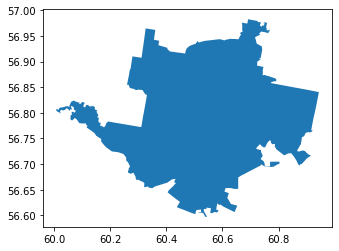

In [127]:
ekb_poly.plot()

<AxesSubplot:>

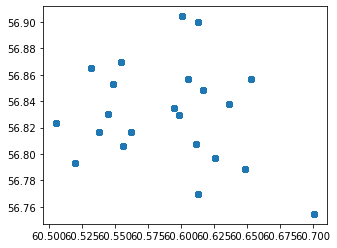

In [124]:
ekb_points.plot()

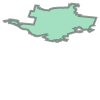

In [143]:
adlvl6[adlvl6['name'] == 'городской округ Екатеринбург'].iloc[0,1]

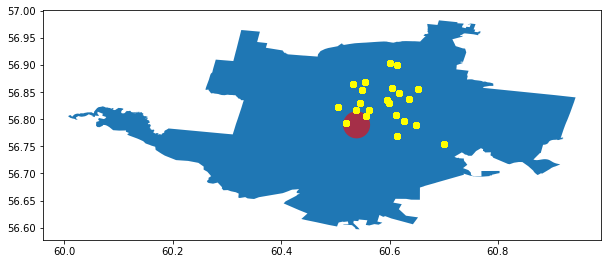

In [516]:
ekat = gpd.GeoDataFrame()
ekat.loc[0,'geometry'] = ekb_poly
buf = gpd.GeoDataFrame()
buf.loc[0,'geometry'] = ekb_poly.centroid.buffer(0.025)



ax = ekat.plot(figsize=(10, 8))
ax = buf.plot(color='r', ax=ax, alpha=0.6)
ax = ekb_points.plot(figsize=(10, 8),ax=ax, color = 'yellow')

In [155]:
ekb_poly.centroid.coords[0][0]

60.53921316286092

In [151]:
import folium
from folium.plugins import HeatMap

In [649]:
m = folium.Map(location=[ekb_poly.centroid.coords[0][1], ekb_poly.centroid.coords[0][0]], 
               zoom_start=11, 
               tiles='cartodbpositron')

HeatMap(ekb_points[['lat','lon', 'target']],
        radius=10).add_to(m)

m

In [181]:
ekb_points.iloc[:,1] = ekb_points.iloc[:,1].astype(float)
ekb_points.iloc[:,2] = ekb_points.iloc[:,2].astype(float)
ekb_points.iloc[:,3] = ekb_points.iloc[:,3].astype(float)

In [650]:
ekb_points[['lat','lon', 'target']].head()

,lat,lon,target
35700,56.769296,60.613168,0.040823
35701,56.769296,60.613168,0.040823
35702,56.769296,60.613168,0.040823
35703,56.769296,60.613168,0.040823
35704,56.769296,60.613168,0.040823


#### Карты Санкт-Петербурга

##### Собираем данные с overpass api, чтоб отобразить их. Карта города составлена из районов.

In [203]:
response = api.get('area[admin_level=4]["name"="Санкт-Петербург"][boundary=administrative]->.arr;(node(area.arr)["aeroway"="aerodrome"];way(area.arr)["aeroway"="aerodrome"];)', verbosity='body geom')

aero = gpd.GeoDataFrame.from_features(response)
aero = aero[['name', 'geometry']]

In [214]:
response = api.get('area[admin_level=4]["name"="Санкт-Петербург"][boundary=administrative]->.arr;(node(area.arr)["railway"="station"];)', verbosity='body geom')
railway = gpd.GeoDataFrame.from_features(response)
railway = railway[['name', 'geometry']]

In [213]:
response = api.get('area[admin_level=4]["name"="Санкт-Петербург"][boundary=administrative]->.arr;(node(area.arr)["landuse"="military"];)', verbosity='body geom')
mil = gpd.GeoDataFrame.from_features(response)
mil = mil['geometry']

In [219]:
response = api.get('area[admin_level=4]["name"="Санкт-Петербург"][boundary=administrative]->.arr;(node(area.arr)["amenity"="prison"];way(area.arr)["amenity"="prison"];)', verbosity='body geom')
prison = gpd.GeoDataFrame.from_features(response)
prison = prison['geometry']

In [224]:
response = api.get('area[admin_level=4]["name"="Санкт-Петербург"][boundary=administrative]->.arr;(node(area.arr)["leisure"="summer_camp"];way(area.arr)["leisure"="summer_camp"];)', verbosity='body geom')
camps = gpd.GeoDataFrame.from_features(response)
camps = camps['geometry']

In [230]:
response = api.get('area[admin_level=4]["name"="Санкт-Петербург"][boundary=administrative]->.arr;(node(area.arr)["railway"="subway_entrance"];way(area.arr)["railway"="subway_entrance"];)', verbosity='body geom')
subway = gpd.GeoDataFrame.from_features(response)
subway = subway['geometry']

In [235]:
response = api.get('area[admin_level=4]["name"="Санкт-Петербург"][boundary=administrative]->.arr;(node(area.arr)["amenity"="social_facility"];way(area.arr)["amenity"="social_facility"];)', verbosity='body geom')
social = gpd.GeoDataFrame.from_features(response)
social = social['geometry']

In [ ]:
spb_poly = adlvl4[adlvl4['name'] == 'Санкт-Петербург'].iloc[0,1]
spb_points = msk_spb[msk_spb['name'] == 'Санкт-Петербург']

In [197]:
spb_points.iloc[:,1] = spb_points.iloc[:,1].astype(float)
spb_points.iloc[:,2] = spb_points.iloc[:,2].astype(float)
spb_points.iloc[:,3] = spb_points.iloc[:,3].astype(float)

In [295]:
adlvl5 = gpd.read_file('GeoJSON/admin_level_5.geojson')
adlvl5 = adlvl5[['name', 'geometry']]

In [296]:
areas = gpd.sjoin(spb_points.drop(columns=['index_right']), adlvl5, op='within')

In [313]:
areas_spb = areas['name_right'].drop_duplicates().values

In [321]:
k = 0
geoms = []
spb = gpd.GeoDataFrame()
for name, geom in adlvl5.values:
    if name in areas_spb:
        geoms.append(geom)
        spb.loc[k,'name'] = name
        k += 1

In [323]:
spb.insert(1,'geometry', geoms)

##### Можем посмотреть расположение всех фичей, что использовали, чтобы не было мешанины - закомментил большую часть, но там все довольно наглядно получается

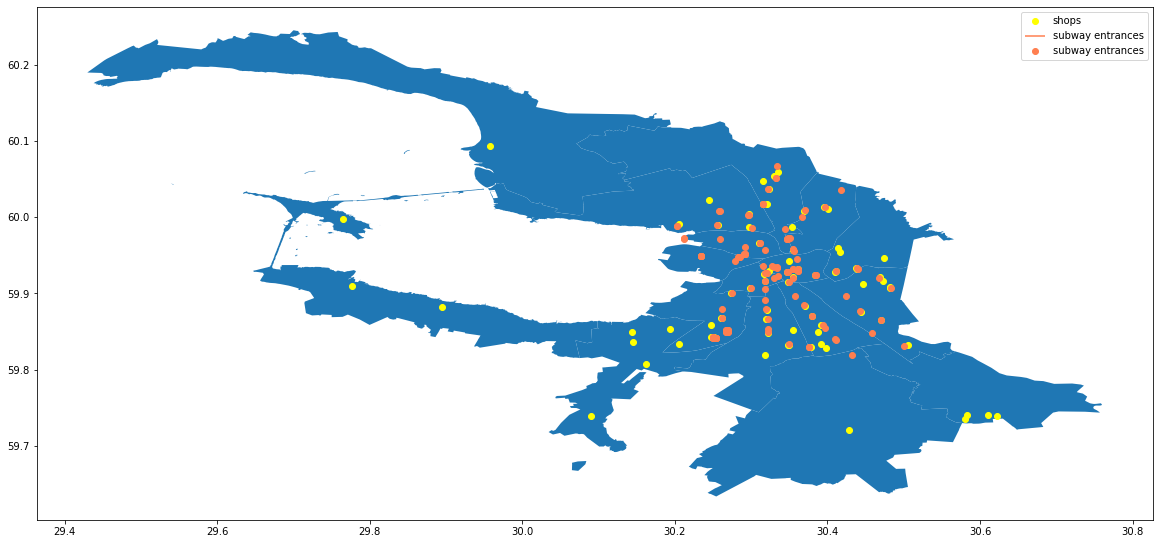

In [521]:
ax = spb.plot(figsize=(20, 16))
#ax = buf.plot(color='r', ax=ax, alpha=0.6)
ax = spb_points.plot(figsize=(20, 16),ax=ax, color = 'yellow', label='shops')
#aero.plot(ax=ax, color = 'red', label='aeroways')
#railway.plot(ax=ax, color = 'grey', label='railway stations')
#mil.plot(ax=ax, color = 'brown', label='military')
#prison.plot(ax=ax, color = 'black', label='prisons')
subway.plot(ax=ax, color = 'coral', label='subway entrances')
#camps.plot(ax=ax, color = 'cyan', label='summer camps')
#social.plot(ax=ax, color = 'lime', label='social houses')
ax.legend()

##### Heatmap демонтсрирующий распределение таргета

In [200]:
m = folium.Map(location=[spb_poly.centroid.coords[0][1], spb_poly.centroid.coords[0][0]], 
               zoom_start=11, 
               tiles='cartodbpositron')

HeatMap(spb_points[['lat','lon', 'target']],
        radius=10).add_to(m)

m

##### Смотрел разные города, прикидывал наиболее удачный радиус для буфферной зоны

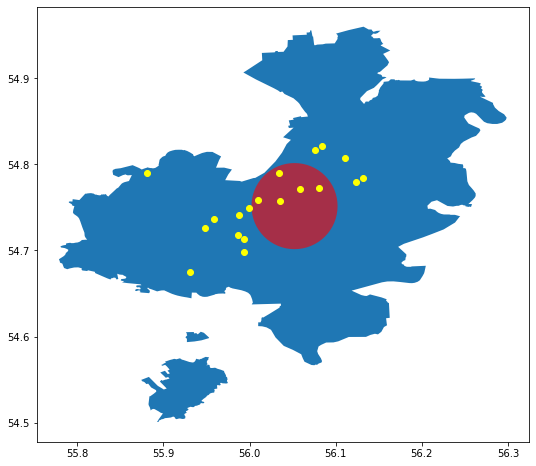

In [641]:
ufa = gpd.GeoDataFrame()
ufa.loc[0,'geometry'] = UFA
buf = gpd.GeoDataFrame()
buf.loc[0,'geometry'] = UFA.centroid.buffer(0.05)



ax = ufa.plot(figsize=(10, 8))
ax = buf.plot(color='r', ax=ax, alpha=0.6)
ax = ru[ru['index_right'] == 39].plot(figsize=(10, 8),ax=ax, color = 'yellow')

### Fit model

In [643]:
train = ru.drop(columns=['name_right','name_left', 'index_right', 'geometry'])

In [608]:
X_train, X_valid, y_train, y_valid = train_test_split(train.drop('target', axis=1), train[['target']])
model = LinearRegression().fit(X_train.drop('point_id', axis=1), y_train)

In [609]:
mean_absolute_error(y_valid, model.predict(X_valid.drop('point_id', axis=1)))

0.796748478479725

In [584]:
train.head()

,point_id,lon,lat,target,closest_prison,closest_railway,closest_tram,closest_military,closest_areo_reg,social_facility,closest_camp_reg,closest_subway,city_center_dist,sub_ents_in_buf
419,YdPYoxfU,30.362054999999998,59.931738,-0.7803583479591522,2.15,2.68,6.50,1.90,12.45,-1.00,-1.00,-1.00,5.52,22
120,PlRVd2q7,30.349681,59.832908999999994,-1.1693392203789554,2.65,0.18,0.14,4.36,31.28,0.71,38.08,0.06,30.81,5
124,gJTsNAnJ,30.379346,59.870262,-1.0396789295723543,5.00,0.37,1.74,4.75,32.18,0.69,39.74,0.16,33.82,5
126,jHHBbyj3,30.320997,59.92681999999999,-0.30493728166828155,4.31,0.15,3.26,3.41,35.23,1.43,23.80,0.08,15.55,26
131,2CRYkkg6,30.315541999999997,60.016895999999996,-0.5642578632814836,5.52,0.19,0.66,5.04,33.80,0.30,21.36,0.06,16.12,8


In [611]:
model = LinearRegression().fit(X = train.drop(['point_id','target'], axis=1), y = train[['target']])

In [644]:
predict = model.predict(train.drop(['target','point_id'], axis=1))

In [645]:
predict.shape

(107, 1)

### Make submission

In [646]:
submission = pd.read_csv('sample_submission.csv')
submission['target'] = predict
submission.to_csv('my_submission_01.csv', index=False)